**Author**: Sami Issaadi

# GCN for Network Anomaly Detection


This notebook introduces methods to use [**Graph Convolutional Network**](https://tkipf.github.io/graph-convolutional-networks/) (**GCN**) to detect anomalies in network flows.
Being able to detect such anomalies could help preventing/stopping network attacks.

## Introduction

### Introduction to GCN

The basic idea behind **GCN** is the aggregation of the features from the neihborhood of each nodes. By repeating this operation $k$ times for a given node $U$, its resulting features is a combination of the features of the $k$-hop neighborhood of $U$.

![GCN Animation Medium](https://miro.medium.com/max/600/1*wt31DAeKTVeDWmPqKprycw.gif)

This simple yet powerfull operation allows us to capture implicit topological information of the node as well as explicit features. The resulting features can be used to determine the role of a node within the sub-graph it belongs to.

> *Incrementing $k$ increases the diameter of the sub-graph from which $U$ is the center, however that doesn't always make the model better since it can lead to [**over-smoothing**](https://arxiv.org/pdf/1812.08434.pdf), which results in obtaining the same features for all the nodes in the graph*

To make it short, GCN propagates nodes features through edges.

### GCN for network anomaly detection

#### Network capture to Graph
A network snapshot can be represented by a graph by considering IPs as nodes and packet exchanges between IPs as edges (*ex: IP_A send TCP request to IP_B*). 

Below is shown a visualization of a network snapshot of 60 seconds:

![Network graph representation](./data/network_image.png)

#### Useful graph geometry

The role of some nodes on the network can be guessed just by watching the graph representation.

> For example, the **DNS** servers are probably the nodes at the center of the big clusters.

We can hence infer that **topological information are meaningful** in those graphs making **GCN** relevant to detect anomalies as detailed [here](https://github.com/harvardnlp/botnet-detection).

#### Needs for more features

However, **topological information are not sufficient** to detect more elabored attacks. For that purpose, **we need more features**, for example:

- IP geographic localization
- IP Reputation score (from websites as [UrlVoid](https://www.urlvoid.com/) for example)
- IP Service Provider (ISP)

However, those are information we don't necesseraly have access on the public datasets we can use to train our model. More generally, **we don't have access to any IP (graph node) related information for privacy reasons**.

#### Edge-based features

Fortunately, we can **interpolate features from packets**, within a certain time window:

- Quantity of bytes (min, mean, median, max, std)
- Number of packets
- Protocol (TCP, UDP, ICMP)
- Frequency
- Connection Probability (that we could generate using another model)
- Exchange history (encoded exchanges history, represented by a vector)
- ...

> That's true for almost all the available public datasets I've worked on: [CTU-13](https://www.stratosphereips.org/datasets-ctu13), [CSE-CIC-IDS2018 (2018)](https://www.unb.ca/cic/datasets/ids-2018.html), [UGR'16 (2016)](https://nesg.ugr.es/nesg-ugr16/index.php).

Unfortunately, **GCNs are not defined to handle features on edges** and require features for nodes that we can not provide.

#### Node features interpolation from edges

Even if we were to have access to private IPs (node) information and therefore would have features on the nodes, we cannot ignore information from IPs interactions (edges).

The issue is that there are, to the best of my knowledge, no researches on the subject.

In this notebook, I try to explore a solution that I've naively entitled **Edge2Node** that consists of **interpolating node features as a combination of the in/out edges**. 

### Requirements
At the time of writting this notebook, there are 3 major Deep Learning Graph libraries in python:

- [Pytorch Geometric](https://github.com/rusty1s/pytorch_geometric)
- [GraphNets](https://github.com/deepmind/graph_nets)
- [Deep Graph Library (DGL)](https://github.com/dmlc/dgl)

There aren't any concrete comparisons between the three yet, so I jut went with the one that attracted me the most. Since I'm more used to **PyTorch**, I've ignored **GraphNets**. **PyTorch-Geometric** implements a lot a GCN papers, however, it seemed a bit rough to me compared to **DGL**, which appeared to have a well thought pipeline and plans for the future.

Conclusion, I had no real reasons to went with **DGL**, that was just intuition.

In [1]:
!pip install --user torch==1.6.0 dgl==0.5.2 networkx==2.4 numpy==1.19.3 matplotlib==3.3.1 tqdm

In [2]:
import torch
import networkx as nx
import numpy as np
from tqdm.notebook import tqdm
import dgl
import dgl.nn

Using backend: pytorch


### Project decomposition

The notebook has required the following steps:

1. Dataset Preparation:
    - Truncate raw PCAP (drop useless data)
    - Slide time Window
    - Extract features for each interaction IP_A to IP_B within window (nb packets, nb bytes sent...)
    - Graph Generation
    
2. GCN Model Design:
    - Generate nodes features from in/out edges (**Edge2Node**)
    - Apply GCN on the graph (using predicted nodes features)
    - Generate edges embedding from new nodes features (**Node2Edge**)
    - Classify nodes and edges using the computed features
    
3. Training:
    - Loss to penalize errors on edge/node classification
    - Basic ML pytorch training loop
    - Model Evaluation
    
However, we will mainly focus on the step **2. GCN Model Design** here since the others steps are just a draft used for the proof of concept. 

## Edge2Node

**Edge2Node** is the method we'll use to interpolate nodes features from edges features.

> The idea is to describe a node as the influence it has on its neighbors and the influence they have on itself.

### Proof Of Concept

In this section, we will apply the **Edge2Node** idea to a toy example.

#### Problem definition

Let's suppose we have the following graph where edges model heat transfer between nodes:

![edge2node_image](./data/edge2node_demo.png)

How can we classify the nodes into the categories: **COLD**, **HOT** ?

##### Intuitive solution

An intuitive solution is to assert that a node is best described by its contribution to the local system stabilization, then the feature $F$ of a node $u$ would be: 

$$F(u) = \sum_{v \in \mathcal{N}_{in}(u)}{W(v, u)}  - \sum_{v \in \mathcal{N}_{out}(u)}{W(u, v)}$$

It can be interpreted as : *A node loses the energy that goes through its out-edges and wins the energy that comes from its in-edges*.

##### Solution application

This process is represented by the following animation:

![edge2node_demo](./data/edge2node.gif)

We calculate that the contribution of the node $A$ to its neighborhood is:

$$F(A) = W(C, A) - W(A, B) = -16 - 20 = -36$$

Hence, the node $A$ loses a lot of heat, there is a **high probability** that it is **HOT** node.

By applying the same idea to the other nodes, we have:
- $B$ gains a **bit** of heat (+4), there is a **slightly higher probability** that it is a **COLD** node
- $C$ gains a **lot** of heat (+32), there is a **high probability** that it is a **COLD** node

#### DGL implementation

In [3]:
class DummyEdgeToNode(torch.nn.Module):
    def forward(self, graph: dgl.DGLGraph, h):
        """
        graph: DGLGraph on which we apply the operation
        h: tensor of all edges features
        """
        h_in  = h  # in-edges  -> energy gain
        h_out = -h # out-edges -> energy loses
        
        # operations on local_scope do not affect the input graph
        with graph.local_scope():
            # shallow copy of the computed `h_in` and `h_out` as edges features
            graph.edata['e_in'] = h_in
            graph.edata['e_out'] = h_out
            
            # 1. Handle IN-EDGES
            # build and apply message passing function to the graph
            graph.update_all(
                # copy in-edges features `e_in` in the mailboxes `n_in` of the nodes
                dgl.function.copy_e('e_in', 'n_in'), 
                # reduce the messages of the mailboxes `n_in` by summing them and store
                # the result into `n_in`
                dgl.function.sum('n_in', 'n_in')
            )
            
            # 2. Handle OUT-EDGES
            # At the time of writing, we can't apply message passing algorithm on out-edges
            # with DGL. The only way I've found is to re-apply the previous logic on the
            # reversed-graph, so the out-edges become in-edges.
            graph = graph.reverse(copy_ndata=True, copy_edata=True)
            graph.update_all(
                dgl.function.copy_e('e_out', 'n_out'), 
                dgl.function.sum('n_out', 'n_out')
            )
            
            return graph.ndata['n_in'] + graph.ndata['n_out']

In [4]:
dummy_e2n = DummyEdgeToNode()

# we create the toy example graph
uv = [0, 1, 2, 2], [1, 2, 1, 0] # directed edges ('A'<=>0, 'B'<=>1, 'C'<=>2)
G = dgl.graph(uv)

# we apply the dummy e2n
edge_features = torch.tensor([20., 12., -4., -16.])
node_features = dummy_e2n(graph=G, h=edge_features).numpy()

## tada!
print(f"A = {node_features[0]}")
print(f"B = {node_features[1]}")
print(f"C = {node_features[2]}")

A = -36.0
B = 4.0
C = 32.0


##### Going Further
This simple idea seems to be enough on a small graph like this one, but what if the graph contained thousands of nodes?

We would need to look further than the direct node neighborhood to truly understand its role on the graph. Now that we have features on the nodes, we can introduce **GCN** to better capture the role of the node within the graph.

### Formula upgrade

The difference between the previously seen **DummyEdgeToNode** and the real one, is that instead of having a fixed (hardcoded) combination, which in our case was:

$$F(u) = \sum_{v \in \mathcal{N}_{in}(u)}{W(v, u)} - \sum_{v \in \mathcal{N}_{out}(u)}{W(u, v)}$$

We use of more complicated one.

The previous formula handles different type of edges on different type of graphs the same way while this is not always relevant. There might be cases when the out-edges have less impact than the in-edge, or cases when a given feature has more impact on out-edges while another one has a negative impact on in-edges.

To handle those various differences (which depend on the type of graphs, edges, features), we use this formula instead:

$$F(u) = \theta(\sum_{v \in \mathcal{N}_{in}(u)}{\sigma(\theta_{in}(W(v, u)))} + \sum_{v \in \mathcal{N}_{out}(u)}{\sigma(\theta_{out}(W(u, v)))})$$

Where:
- $\sigma$ is a non-linear function (ex: RElu, sigmoid, tanh...)
- $\theta, \theta_{in}, \theta_{out}$ are function with parameters to be optimized (ex: Linear torch layer)
- $W(u, v)$ returns the features of the edge $(u,v)$

> There are no restrictions on $\theta, \theta_{in}, \theta_{out}$ (e.g. it can be a deep CNN as it can be a simple linear layer)

It should allow **Edge2Node** to scale to different graphs.

In [5]:
class EdgeToNode(torch.nn.Module):
    def __init__(self, in_features, hid_features, out_features, non_linear=None):
        super().__init__()
        self.linear_in = torch.nn.Linear(in_features, hid_features) # theta_in
        self.linear_out = torch.nn.Linear(in_features, hid_features) # theta_out
        self.linear_final = torch.nn.Linear(hid_features, out_features) # theta
        self.non_linear = non_linear or torch.nn.Identity()
        
    def forward(self, graph: dgl.DGLGraph, h):
        # apply theta_in and theta_out to edges features
        h_in, h_out = self.linear_in(h), self.linear_out(h)
        # apply sigma (non_linear) to `h_in` and `h_out`
        h_in, h_out = self.non_linear(h_in), self.non_linear(h_out)
        
        with graph.local_scope(): 
            graph.edata['e_in'] = h_in
            graph.edata['e_out'] = h_out
            
            graph.update_all(
                dgl.function.copy_e('e_in', 'n_in'),
                dgl.function.sum('n_in', 'n_in')
            ) 
            
            graph = graph.reverse(copy_ndata=True, copy_edata=True) 
            graph.update_all(
                dgl.function.copy_e('e_out', 'n_out'),
                dgl.function.sum('n_out', 'n_out')
            ) 
            
            return self.linear_final(graph.ndata['n_in'] + graph.ndata['n_out'])

### Node2Edge

For edge classification, we need to do the process inverse of **Edge2Node**. In fact, after we've applied a GCN to have meaningful node embedding, we need to "send" those information on edges. 

This can be done the following way:

$$W(u, v) = \theta( \sigma(\theta_{src}(F(u))) + \sigma(\theta_{dst}(F(v))) )$$

The intuition behind is the same as **Edge2Node**

In [6]:
class NodeToEdge(torch.nn.Module):
    def __init__(self, in_features, hid_features, out_features, non_linear=None):
        super().__init__()
        self.linear_src = torch.nn.Linear(in_features, hid_features)
        self.linear_dst = torch.nn.Linear(in_features, hid_features)
        self.linear_final = torch.nn.Linear(hid_features, out_features)
        self.non_linear = non_linear or torch.nn.Identity()
        
    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.edata['h'] = torch.zeros((graph.number_of_edges(), h.shape[-1]))
            
            graph.apply_edges(dgl.function.e_add_u('h', 'h', 'h_src'))
            graph.apply_edges(dgl.function.e_add_v('h', 'h', 'h_dst'))
            
            h_src = self.linear_src(graph.edata['h_src'])
            h_dst = self.linear_dst(graph.edata['h_dst'])
            
            h_src = self.non_linear(h_src)
            h_dst = self.non_linear(h_dst)
            
            return self.linear_final(h_src + h_dst)

### Demonstration of synthetic data

We will now try node classification on a **synthetic dataset** to demonstrate the validity of **Edge2Node**, for that, we:

- Generate a random graph
- For each node, we generate synthetic features that describe a class among a fixed number of classes
- Generate edge features from the synthetic node features
- Train a model to predict node classes solely based on the edge features

#### Data generation

In [7]:
from sklearn.datasets import make_gaussian_quantiles
def generate_graph(n2e, n_nodes, n_ft_nodes=10, n_ft_edges=None, n_classes=8, cov=3):
    n_ft_edges = n_ft_edges or 2*n_ft_nodes
    
    g = nx.barabasi_albert_graph(n_nodes, 1)
    g = dgl.from_networkx(g)
    
    x, y = make_gaussian_quantiles(
        cov=cov, n_classes=n_classes, 
        n_features=n_ft_nodes, n_samples=n_nodes
    )
    x, y = torch.from_numpy(x).float(), torch.from_numpy(y).long()
    g.ndata['ft'] = x
    g.ndata['y'] = y
    
    with torch.no_grad():
        g.edata['ft'] = n2e(g, g.ndata['ft'])
        
    return g

n_features_nodes = 8
n_features_edges = 32
n_classes = 10
n2e = NodeToEdge(
    in_features=n_features_nodes,
    hid_features=3*n_features_nodes,
    out_features=n_features_edges,
    non_linear=torch.nn.ReLU(),
)

In [8]:
from torch.utils.data import random_split
# generate 200 synthetic graphs
dt = [
    generate_graph(
        n2e, 
        n_nodes=np.random.randint(100, 4000),
        n_ft_nodes=n_features_nodes,
        n_ft_edges=n_features_edges, 
        n_classes=n_classes
    )  for _ in tqdm(range(200))
]

dt_train, dt_val, dt_test = random_split(
    dt, 
    (len(dt) * np.array([0.7, 0.2, 0.1])).astype(int)
)

#### Baseline

Before training and evaluating the **NodePredictor**, we need baselines for comparisons.

- **Random**: the accuracy of such a model is 1/n_classes, for n_classes=10, we accuracy score is 0.1 . This gives us the **minimal performance** our model needs to achieve.
- **ML Classifier** trained on the **original nodes features**. This gives us the **maximal performance** our model should be able to achieve.

> The reason why the **ML Classifier** should give the **maximal performance** possible for our **GCN-based Classifier** is that the class of a node depends solely on its own features. Hence, the **nodes relationships are meaningless** for the classification. Moreover, the ML Classifier will work directly on the **non-altered nodes features**, while the GCN Classifier has to interpolate them from the edges using **Edge2Node**.

In [9]:
from helper import *

model = torch.nn.Sequential(
    torch.nn.Linear(n_features_nodes, n_features_nodes * 2),
    torch.nn.ReLU(),
    torch.nn.Linear(n_features_nodes * 2, n_features_nodes * 2),
    torch.nn.ReLU(),
    torch.nn.Linear(n_features_nodes * 2, n_classes),
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()
trainSimple(model, 
    optimizer, 
    criterion, 
    lambda f,g: f(g.ndata['ft']),  # forward method
    dt_train, 
    dt_val, 
    dt_test, 
    nb_epochs=20
)

Before:
	loss_val: 2.325 / acc_val: 0.104
	loss_test: 2.326 / acc_tes: 0.105


epoch 000: loss_val:2.209, acc: 0.139


epoch 001: loss_val:1.908, acc: 0.287


epoch 002: loss_val:1.559, acc: 0.435


epoch 003: loss_val:1.355, acc: 0.493


epoch 004: loss_val:1.249, acc: 0.512


epoch 005: loss_val:1.188, acc: 0.519


epoch 006: loss_val:1.150, acc: 0.525


epoch 007: loss_val:1.124, acc: 0.528


epoch 008: loss_val:1.105, acc: 0.531


epoch 009: loss_val:1.091, acc: 0.533


epoch 010: loss_val:1.080, acc: 0.534


epoch 011: loss_val:1.071, acc: 0.535


epoch 012: loss_val:1.064, acc: 0.536


epoch 013: loss_val:1.058, acc: 0.538


epoch 014: loss_val:1.053, acc: 0.539


epoch 015: loss_val:1.049, acc: 0.540


epoch 016: loss_val:1.045, acc: 0.542


epoch 017: loss_val:1.041, acc: 0.542


epoch 018: loss_val:1.038, acc: 0.543


epoch 019: loss_val:1.035, acc: 0.544



After:
	loss_val: 1.035 / acc_val: 0.544
	loss_test: 1.059 / acc_tes: 0.541


#### GCN Model definition

In [10]:
import torch.nn.functional as F


# Simple SAGE model for GCN depth 2
class SAGE(torch.nn.Module):
    def __init__(self, in_features, hid_features, out_features):
        super().__init__()
        self.conv1 = dgl.nn.SAGEConv(
            in_feats=in_features, 
            out_feats=hid_features,
            aggregator_type='mean'
        )
        self.conv2 = dgl.nn.SAGEConv(
            in_feats=hid_features, 
            out_feats=out_features,
            aggregator_type='mean'
        )

    def forward(self, graph, h):    
        h = F.relu(self.conv1(graph, h))
        h = self.conv2(graph, h)
        return h
    
    
# Node class prediction
class NodePredictor(torch.nn.Module):
    def __init__(self, n_classes, in_features_e, out_features_e=16, hid_features_n=32, out_features_n=16):
        super().__init__()
        
        self.e2n = EdgeToNode(
            in_features=in_features_e, 
            hid_features=hid_features_n, 
            out_features=out_features_e, 
            non_linear=torch.nn.ReLU()
        )
        self.sage = SAGE(out_features_e, hid_features_n, out_features_n)
        self.n2y = torch.nn.Linear(out_features_n, n_classes)
        
    def forward(self, graph, h):    
        h = self.e2n(graph, h)
        h = torch.tanh(h)
        h = self.sage(graph, h)
        h = torch.relu(h)
        
        return self.n2y(h)

In [11]:
model = NodePredictor(n_classes, n_features_edges)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
trainSimple(model, optimizer, criterion, lambda f, g: f(g, g.edata['ft']), dt_train, dt_val, dt_test, nb_epochs=20)

Before:
	loss_val: 2.476 / acc_val: 0.100
	loss_test: 2.474 / acc_tes: 0.100


epoch 000: loss_val:2.279, acc: 0.131


epoch 001: loss_val:1.847, acc: 0.257


epoch 002: loss_val:1.536, acc: 0.366


epoch 003: loss_val:1.446, acc: 0.398


epoch 004: loss_val:1.412, acc: 0.409


epoch 005: loss_val:1.388, acc: 0.416


epoch 006: loss_val:1.396, acc: 0.414


epoch 007: loss_val:1.379, acc: 0.418


epoch 008: loss_val:1.346, acc: 0.432


epoch 009: loss_val:1.337, acc: 0.435


epoch 010: loss_val:1.326, acc: 0.438


epoch 011: loss_val:1.316, acc: 0.440


epoch 012: loss_val:1.309, acc: 0.444


epoch 013: loss_val:1.310, acc: 0.442


epoch 014: loss_val:1.295, acc: 0.449


epoch 015: loss_val:1.289, acc: 0.448


epoch 016: loss_val:1.284, acc: 0.451


epoch 017: loss_val:1.274, acc: 0.454


epoch 018: loss_val:1.270, acc: 0.457


epoch 019: loss_val:1.267, acc: 0.456



After:
	loss_val: 1.267 / acc_val: 0.456
	loss_test: 1.274 / acc_tes: 0.454


#### Observation

The **GCN-based** classifier performs better than random draws and is not too far from the ideal baseline classifier.

It can then be concluded that **Edge2Node** isn't totally irrelevant.

## Anomaly detection on CTU13

### Data pre-processing

As explained previously, the data pre-processing is not the main focus of this notebook, we will therefore directly use **data already pre-processed**.

> Still, the **pre-processing code is available on the repository**.

The dataset is originally divided into different scenarios, each representing different attacks configurations. To transform the raw data into graphs, we:
- extract **constant duration snapshots** by sliding a time window of **60 seconds**
- set label *unknown* to all exchanges, then set *benign* to all exchanges for which the IP_src or IP_dst is known as *benign*, and finally set *malicious* to exchanges that contains a malicious IP
- group packets by: IP (SRC+DST), port (SRC+DST), protocol (TCP|UDP|ICMP), label (*unknown, benign, malicious*) and aggregate some features
- normalize by the time (60 seconds in this case)

Hence, for each unique pairs of (IPs, PORTs, PROTOCOL, LABEL), we have the following vector of features: \[EXCHANGE_DURATION, MEAN_BYTES_PER_PACKET, MEDIAN_BYTES_PER_PACKET, NB_PACKETS, TOTALE_BYTES_SENT\].

> The information of *PORT* and *PROTOCOL* won't be used here because this would require to build [Heterogeneous Graphs](https://docs.dgl.ai/en/0.4.x/tutorials/hetero/1_basics.html), which would have made things a bit harder. Nevertheless, those features are meaningful, and we could probably achieve better result by considering them.

As a remember, the nodes are the IPs, the edge are the exchanges between those IPs within the time window, and those edges have as features the vector described above.

### Download processed data

At the time of writing, I had no access to service for file sharing with direct link download, so there is no automagick dataset downloading code. To continue the execution of this notebook, please download the following archive: [**ctu13-graphs.tar.gz**](https://drive.google.com/file/d/1TIow659IWelNWqnqJUMpwVNq1LDo-lyA).

In [12]:
from pathlib import Path
PATH_DT_ARCHIVE = "./data/ctu13-graphs.tar.gz"
PATH_DT = "./data/ctu13-graphs"
PATH_DT_CACHE = "./.cache/dgl/ctu13"
assert Path(PATH_DT_ARCHIVE).exists(), "You must download the archive `ctu13-graphs.tar.gz`: https://drive.google.com/file/d/1TIow659IWelNWqnqJUMpwVNq1LDo-lyA/view?usp=sharing"
print("Archive extraction...")
! ! [ -d $PATH_DT ] && mkdir $PATH_DT && \
    ((pv $PATH_DT_ARCHIVE | tar xzp -C $PATH_DT) || rm -r $PATH_DT)
if _exit_code == 0:
    print("An error occured")
else:
    print("Done!")

Archive extraction...
Done!


### Data generation

#### DGL Dataset

To generate the data, we just have to load it from the already pre-processed data.
> The first execution will generate a cache, this can take a few minutes.

In [13]:
from helper import CTU13Dataset
dt = CTU13Dataset(raw_dir=PATH_DT, save_dir=PATH_DT_CACHE)

####  Dataset splitting

We distribute the dataset, in this case, the different graphs, into *training*, *validation* and *test* sets.

This is important to note that the graphs are ordered by scenario and by time. Therefore, performing a **random split** implies that the *training*, *validation* and *test* sets contain the **same scenarios** at different time. Disabling the random split avoids this situation, making the different sets contain graphs generated from different scenarios:

- `shuffle=True`: evaluate on **known scenarios**
- `shuffle=False`: evaluate on **unknown scenarios**

In [14]:
dt_train, dt_val, dt_test = dgl.data.utils.split_dataset(
    dt,
    frac_list=[0.7, 0.15, 0.15],
    shuffle=True,
)
len(dt_train), len(dt_val), len(dt_test)

(1210, 259, 260)

> Enabling the `shuffle` completely change the purpose of the model and hence the performance. It is not possible to achieve great result when `shuffle=False` because of the poor quality of features we are using to detect the anomalies, fortunately, there is still room for enhancement. Details are discussed at the end of the notebook.

### Model definition

The model is simply made of what has been describe so on. It is worth notice that the `forward` method returns two values:

- `pred_node`: prediction of the node class (*benign|malicious*)
- `pred_edges`: prediction of the edge class (*benign|malicious*)

In fact, the model will be trained on the classification it outputs for the edges and for the nodes as well.

In [15]:
class CTU13Predictor(torch.nn.Module):
    def __init__(self, in_features_e, hid_features_e=32, out_features_e=16, hid_features_n=32, out_features_n=16, n_classes=2):
        super().__init__()
        
        self.e2n = EdgeToNode(in_features_e, hid_features_e, out_features_e, torch.nn.ReLU())
        self.lin1 = torch.nn.Linear(out_features_e, out_features_e)
        self.sage = SAGE(out_features_e, hid_features_n, out_features_n)
        self.lin2 = torch.nn.Linear(out_features_n, out_features_n)
        self.n2y = torch.nn.Linear(out_features_n, n_classes)
        self.n2e = NodeToEdge(out_features_n, hid_features_n, n_classes)
        
    def forward(self, graph, h):    
        h = self.e2n(graph, h)
        h = torch.tanh(h)
        h = self.lin1(h)
        h = torch.relu(h)
        h = self.sage(graph, h)
        h = torch.relu(h)
        h = self.lin2(h)
#         h = torch.relu(h)
        
        pred_node = self.n2y(h)
        pred_edge = self.n2e(graph, h)
        
        return pred_node, pred_edge

In [16]:
model = CTU13Predictor(
    in_features_e=5, 
    hid_features_e=16, 
    out_features_e=16, 
    hid_features_n=32, 
    out_features_n=16
)

### Model training

#### Label imbalance

As you might expect, the dataset is highly imbalanced since malicious exchanges are rare. This is why we need to ponderate the loss.

Here we calculate the weights of each class:

In [17]:
nb_malicious, nb_tot = 0, 0
nb_malicious_n, nb_tot_n = 0, 0
for (_, labels) in tqdm(dt_train):
    y = labels['edge'] == CTU13Dataset.label_malicious
    nb_malicious += y.sum().item()
    nb_tot += len(y)
    
ratio = nb_malicious/nb_tot
weights = 100*torch.tensor([ratio, 1.0-ratio])
weights

tensor([ 0.7456, 99.2544])

#### Loss function

As explained earlier, the model outputs 2 predictions:
- node classification
- edge classification

The loss used for each is the **CrossEntropyLoss** since it allows to easily weight the different classes.

We combine the losses we obtain with a linear interpolation.

In [18]:
CST_WEIGHTING_EDGE = 0.7

# this method generate the loss function
def make_lerp_loss_fct(criterion, alpha):
    def fct(y_pred_n, y_pred_e, y_true_n, y_true_e):
        # loss on node classification
        loss_n = criterion(y_pred_n, y_true_n)
        # loss on edge classification
        loss_e = criterion(y_pred_e, y_true_e)
        # loss as linear interpolation from loss_node to loss_edge
        return (1.0 - alpha) * loss_n + alpha * loss_e
    return fct

criterion = make_lerp_loss_fct(
    criterion=torch.nn.CrossEntropyLoss(weight=weights),
    alpha=CST_WEIGHTING_EDGE,
)

#### Metrics display

During the training, the only shown metrics are the following one:
- Loss (loss)
- True Positive malicious (acc): ratio of malicious correctly detected

> The TP_Malicious is represented by 'acc' on the prints because there was not enough place to print the real metric name. **Be careful to not confuse it to the accuracy of the model**, which is not too relevant given the high imbalance.

The metrics are computed for:
- the training set: `[a-z]+_train`
- the validation set: `[a-z]+_val`
- the test set: `[a-z]+_test`

And that's done for:
- Nodes: `[a-z]+_[a-z]+_n`
- Edges: `[a-z]+_[a-z]+_e`

> Those metrics are not enough to correctly evaluate the validity of the model, however, it was not possible to print too much metrics during the training.

In [19]:
from helper import trainCTU13
optimizer = torch.optim.Adam(model.parameters())
trainCTU13(model, optimizer, criterion, dt_train, dt_val, dt_test, nb_epochs=10)

Before train:
	 Validation: loss:0.632 | acc_n:0.001 | acc_e: 0.379
	 Test      : loss:0.632 | acc_n:0.002 | acc_e: 0.396


epoch 0: loss_train=0.141 loss_val=0.085 | acc_train_n=0.633 acc_val_n=0.015 | acc_train_e=0.909 acc_val_e=0.941


epoch 1: loss_train=0.080 loss_val=0.070 | acc_train_n=0.755 acc_val_n=0.015 | acc_train_e=0.959 acc_val_e=0.969


epoch 2: loss_train=0.065 loss_val=0.077 | acc_train_n=0.773 acc_val_n=0.014 | acc_train_e=0.972 acc_val_e=0.881


epoch 3: loss_train=0.068 loss_val=0.053 | acc_train_n=0.767 acc_val_n=0.016 | acc_train_e=0.961 acc_val_e=0.971


epoch 4: loss_train=0.073 loss_val=0.069 | acc_train_n=0.752 acc_val_n=0.014 | acc_train_e=0.948 acc_val_e=0.896


epoch 5: loss_train=0.060 loss_val=0.051 | acc_train_n=0.808 acc_val_n=0.016 | acc_train_e=0.961 acc_val_e=0.969


epoch 6: loss_train=0.058 loss_val=0.053 | acc_train_n=0.827 acc_val_n=0.017 | acc_train_e=0.965 acc_val_e=0.982


epoch 7: loss_train=0.051 loss_val=0.040 | acc_train_n=0.864 acc_val_n=0.017 | acc_train_e=0.976 acc_val_e=0.988


epoch 8: loss_train=0.047 loss_val=0.039 | acc_train_n=0.876 acc_val_n=0.017 | acc_train_e=0.975 acc_val_e=0.986


epoch 9: loss_train=0.042 loss_val=0.031 | acc_train_n=0.878 acc_val_n=0.018 | acc_train_e=0.979 acc_val_e=0.984



After train:
	 Validation: loss:0.031 | acc_n:0.018 | acc_e: 0.984
	 Test      : loss:0.035 | acc_n:0.020 | acc_e: 0.972


### Evaluation

Evaluation on Train Dataset:


Eval Edges Classification:
              precision    recall  f1-score   support

      normal       1.00      0.99      1.00  12021831
   malicious       0.50      0.99      0.67     90308

    accuracy                           0.99  12112139
   macro avg       0.75      0.99      0.83  12112139
weighted avg       1.00      0.99      0.99  12112139



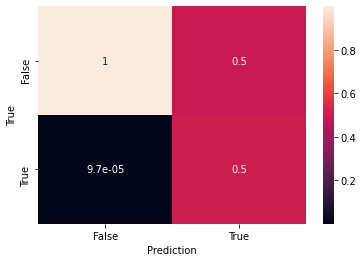

Evaluation on Validation Dataset:


Eval Edges Classification:
              precision    recall  f1-score   support

      normal       1.00      0.99      1.00   2661967
   malicious       0.53      0.98      0.69     20173

    accuracy                           0.99   2682140
   macro avg       0.76      0.99      0.84   2682140
weighted avg       1.00      0.99      0.99   2682140



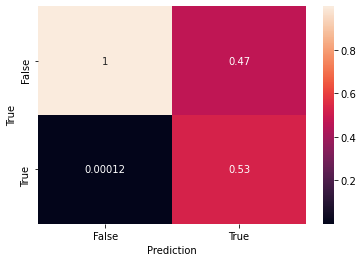

Evaluation on Test Dataset:


Eval Edges Classification:
              precision    recall  f1-score   support

      normal       1.00      0.99      1.00   2529973
   malicious       0.46      0.97      0.62     17773

    accuracy                           0.99   2547746
   macro avg       0.73      0.98      0.81   2547746
weighted avg       1.00      0.99      0.99   2547746



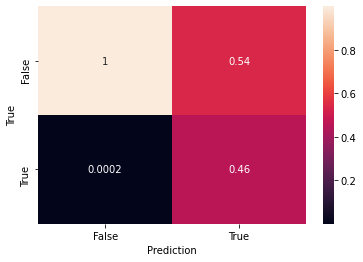

In [20]:
from helper import classification_report_dataset
print("Evaluation on Train Dataset:")
classification_report_dataset(model, dt_train, show_on_nodes=False)
print("Evaluation on Validation Dataset:")
classification_report_dataset(model, dt_val, show_on_nodes=False)
print("Evaluation on Test Dataset:")
classification_report_dataset(model, dt_test, show_on_nodes=False)

## Conclusion

As explained previously, the performances of the model depend on the way we split the dataset. We can either evaluate the model on known scenarios, or on unknown ones.

> The model performs poorly for node classification on known and unknown scenarios. It is probably due to the higher dataset imbalance we have for nodes (~ 1 malicious for 16k benigns in average). However, I haven't investigated more.

We will only focus on the performance on edges.

### On unknown scenarios (`shuffle=False`)

The model is inexploitable as it is now. The performances on the evaluation/test sets are deplorable. This could be explained the following issues:

- The **current features are poor** and there are just **not enough**. *Even for the world's best expert, it would not be possible to correctly predict malicious edges/nodes just with information generated from size/number of packets within a frame of time of 60 seconds.
- The data is **too imbalanced**. *Simply weighting the loss function is not enough*
- Not enough data and scenarios. *There aren't enough scenarios*.
- The **model is too simple**

### On known scenarios (`shuffle=True`)

On known scenarios, we are affected by the issues mentioned above, nevertheless, the problem being way more simple, the performances are less affected. We can do the following observations:
- Almost no False Positive for `Benign`
- Precision for `Malicious` edges is correct (~40%)

## Discussion

### The movie analogy
To make the discussion easier and better understand the problem, let's make the analogy with a **fight detector**, a model that detects fights and their location within a movie **[scene](https://en.wikipedia.org/wiki/Scene_(filmmaking))**.

- **Scenarios of CTU13** would be equivalent to a movie scene, we have 13 scenarios, hence 13 scenes.
- **Graphs representing exchanges within a time window** within a scenario, would be equivalent to a **sequence of frames** within a scene of a movie.
- **Malicious edge/node** in a graph is equivalent to a **fight in a frame**.

### Why do we get such low performances?

- **Not enough scenarios**: with only 13 movie scenes that contain a small amount of frame with fights, how could we possibly teach a **fight detector** generalize the notion of fight?
- **Not enough malicious snapshots**: approximately 1/10th of the graphs contains real anomalies ~(150/1300).
- **Poor features**: *(more on that on the last section)*
- **Highly imbalanced dataset**, this could translate as having 100 pixels representing a fight in a frame that contains millions of pixels (e.g 1080*1920)
- **Too simple model**: the **fight detector** just won't work well with a naive fully connected neural network, but we used a GCN equivalent (in term of simplicity) in this notebook

This justifify the poor performances obtained.

## Is it relevant to evaluate the model on known scenarios?

One could argue that training and evaluating on data from the same scenarios from the same network configuration is cheating. I think it is.

It would be equivalent to teach a **fight detector** that two entities are fighting on some frames extracted from the same scene, and then, asking it to determine if the same individuals are fighting a few frames before/meanwhile/after.

The scene remains globally the same between the two frames (e.g. same room, same illumination, same entities), hence our model is **not evaluated on its ability to recognize fights in general**, but on its ability to **recognize a fight in that particular scene.** 

The same logic applies with this network anomaly detection scheme. Therefore, this would not be right to affirm that the model can detect network anomalies.

> Fortunately, we can imagine scenarios where it is still relevant. For example on networks that do not vary a lot through time and where we want to detect just certain type of anomalies.

## Going further

### Adding features

The dataset contains only 5 features on edges, and none on nodes. **This is not enough** given the complexity of the task.

Adding more features to the dataset would probably have a great impact.

To make the analogy with the **figth detector**: when given the task to localize fights in movie, an individual would always take into consideration his **prior knowledge** as well as the few **previous movie frames**.

#### Prior knowledge

In our case this would relate to any information we have a priori about the nodes (IPs), the edges (pair of nodes). When making the analogy, this would give us this kind of information:

- is this movie for adults? Is it for children?
- what is the relation between those two movie characters? Are they friendly? Are they opposed?
- is it an action movie?
- is this character aggressive?

Those information are used to biases the model's prediction (e.g. lowering the probability that the **figth detector** detects a fight between two friends).

#### Temporal information

A fight is an action that can be ambiguous and hard to detect when considering each movie frames independently. *Is the black cat going to ferociously slap the other cat, or friendly stroke it?*

![slap-cat](./data/cat.jpg)

The same goes on network anomaly detection. Solely considering a graph (frame) without considering its history (previous graphs) does not give us enough information. It is inconceivable to detect elabored attacks without considering temporal information.

With last frames analysis, we get this kind of information:
- were there any entities able to fight in this frame (e.g. human, cat) ?
- what is the motion of this action? Is it fast? Is it soft?

#### Prior and temporal knowledge for graphs

We need this same prior knownledge for the nodes (e.g. is it an aggressive one?), for the pair of nodes (e.g. do they like each other?), and so on. And because prior knowledge can evolve through time, we need to track it as well. 

We also need this ability to track the graph evolution by taking into consideration the last N graphs, and the last N edges.

### Adding RNNs to the model

As explained above, we need temporal knowledge about nodes and edges. One way to do so is to use RNNs [Recurrent Neural Network](https://en.wikipedia.org/wiki/Recurrent_neural_network):

To integrate it for the nodes for example, we could apply the following algorithm:
- Initialize node features as a vector $S_i$ of features (initially filled with 0s). *This vector of features represent the accumulated knowledge on this node: prior and temporal knowledge*
- Feed the RNN module with as input the current data (e.g features obtained from **Edge2Vec**), and as state the vector $S_i$
- Use the RNNs output for prediction
- Store the new state $S_{i+1}$ for next prediction

> This is simple to implement, however, this requires few modifications to the generated dataset. That's why I haven't tried the idea in this notebook.

# Thanks for reading